In [85]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
from data_loader import load_data
from data_preprocesser import preprocess_data
from radial import RadialFlow

Data successfully loaded...

Data successfully preprocessed...

x0 shape: (1, 2)


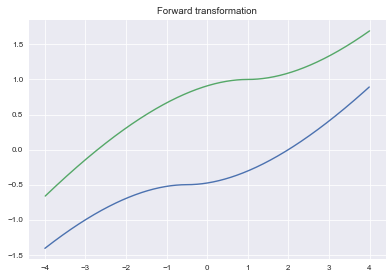

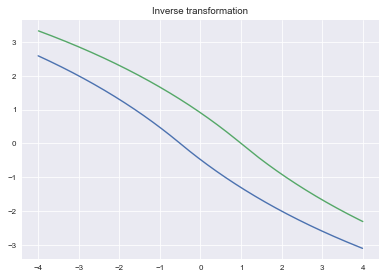

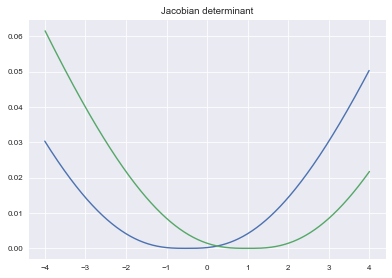

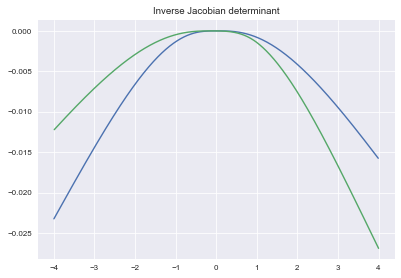

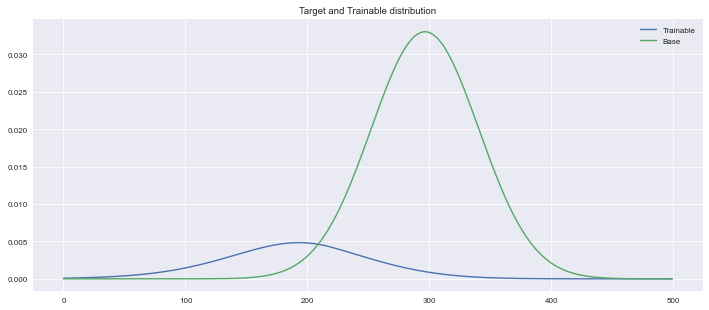

TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


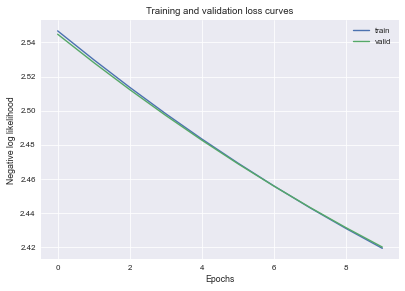

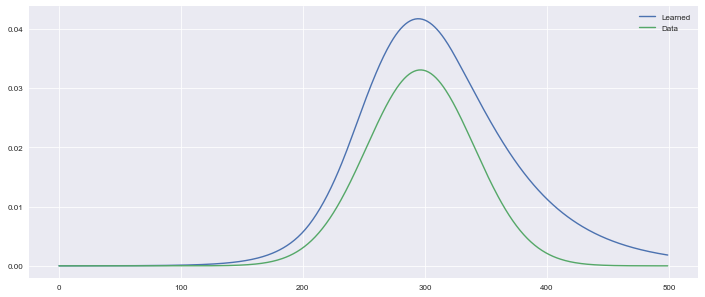

In [94]:
def main():
    
    tfd = tfp.distributions
    tfb = tfp.bijectors
    
    """ load data """

    filename = 'prostate.xls'
    directory = '/Users/kaanguney.keklikci/Data/'

    loader = load_data(filename, directory)
    loader.create_directory(directory)
    data = loader.read_data(directory, filename)
    print('Data successfully loaded...\n')

    """ preprocess data """

    fillna_vals = ['sz', 'sg', 'wt']
    dropna_vals = ['ekg', 'age']
    drop_vals = ['patno', 'sdate']

    preprocesser = preprocess_data(StandardScaler(), fillna_vals, dropna_vals, drop_vals)
    data = preprocesser.dropna_features(data)
    data = preprocesser.impute(data)
    data = preprocesser.drop_features(data)
    data = preprocesser.encode_categorical(data)
    data = preprocesser.scale(data)
    print('Data successfully preprocessed...\n')
    
    """ define the base distributon as bivariate gaussian """

    base_dist = tfd.Independent(tfd.Normal(loc=[2., -0.5], scale=[1.,1.]),
                              reinterpreted_batch_ndims=1)
    
    """ instantiate the bijector (a,b,x0) """

    n = 1000
    a = 10.
    b = -10.
    x0 = np.array([-0.5,1.]).astype(np.float32).reshape(-1, 2)
    bijector = RadialFlow(a, b, x0)
    print(f'x0 shape: {x0.shape}')

    x = np.linspace(start=-4, stop=4, num=n).astype(np.float32).reshape(-1, 2)
    plt.title('Forward transformation')
    plt.plot(x, bijector.forward(x))
    plt.show()
  
    plt.plot(x, bijector.inverse(x))
    plt.title('Inverse transformation')
    plt.show()
 
    plt.plot(x, bijector.forward_log_det_jacobian(x))
    plt.title('Jacobian determinant')
    plt.show()
    
    plt.plot(x, bijector.inverse_log_det_jacobian(x))
    plt.title('Inverse Jacobian determinant')
    plt.show()
    
    """ create transformed distribution """
    tfd_dist = tfd.TransformedDistribution(distribution=base_dist, 
                                           bijector=bijector
                                         )
    # prior training

    plt.figure(figsize=(12,5))
    plt.plot(tfd_dist.prob(x), label='Trainable')
    plt.plot(base_dist.prob(x), label='Base')
    plt.title('Target and Trainable distribution')
    plt.legend()
    plt.show()
    
    # sample, batch -- train, validation 
    
    x_train = base_dist.sample(10000)
    x_train = tf.data.Dataset.from_tensor_slices(x_train)
    x_train = x_train.batch(int(n/2))

    x_valid = base_dist.sample(1000)
    x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
    x_valid = x_valid.batch(int(n/2))

    print(x_train.element_spec)
    print(x_valid.element_spec)
    print()
    
    # instantiate trainable bijector 

    trainable_bijector = RadialFlow(tf.Variable(a, 
                                            name='alpha'), 
                                    tf.Variable(b, 
                                            name='beta'), 
                                    tf.Variable(x0, 
                                            name='ref'))
                                   

    # instantiate trainable distribution 

    trainable_dist = tfd.TransformedDistribution(tfd_dist, 
                                                 trainable_bijector
                                                )
    
    # Train the bijector
    
    num_epochs = 10
    opt = tf.keras.optimizers.Adam()
    train_losses = []
    valid_losses = []
    norm = 1e3

    for epoch in range(num_epochs):
        print("Epoch {}...".format(epoch))
        train_loss = tf.keras.metrics.Mean()
        val_loss = tf.keras.metrics.Mean()
        for train_batch in x_train:
            with tf.GradientTape() as tape:
                tape.watch(trainable_bijector.trainable_variables)
                loss = -trainable_dist.log_prob(train_batch)
            train_loss(loss)
            grads = tape.gradient(loss, trainable_bijector.trainable_variables)
            grads, _ = tf.clip_by_global_norm(grads, norm) 
            # grads = tf.reshape(tf.nn.softmax(grads[-1], axis=1), [2])
            # note that both alternatives work almost identically
            opt.apply_gradients(zip(grads, trainable_bijector.trainable_variables))
        train_losses.append(train_loss.result().numpy())
        # validation
        for valid_batch in x_valid:
            loss = -trainable_dist.log_prob(valid_batch)
            val_loss(loss)
        valid_losses.append(val_loss.result().numpy())
        
    # Plot the learning curves

    plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Negative log likelihood")
    plt.title("Training and validation loss curves")
    plt.show()
    
    # Plot the data and learned distributions

    plt.figure(figsize=(12,5))
    plt.plot(trainable_dist.prob(x), label='Learned')
    plt.plot(base_dist.prob(x), label='Data')
    plt.legend()
    plt.show()
    
    ### best result obtained with tuning displayed as above
    ### radial flows converge fast, more epochs overfit
    ### DO NOT CHANGE validate_args=True

if __name__ == '__main__':
    main()

In [68]:
### DOES NOT USE DATASET YET
### FOR VISUALIZATION PURPOSES IN 2D
### WILL INTEGRATE DATASET AFTER LEARNING THE DISTRIBUTION